In [2]:
import os,sys
import torch_sparse
from skimage import color
import numpy as np
import tensorflow as tf # just for DeepMind's dataset
import torch
import torchvision
from torch_geometric.utils import to_dense_batch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from PSGNetLite import *
from objectsRoomLoader import *

device = "cuda:0"
import torch_sparse

# Should move these two functions below to another file

# From SRN utils, just formats a flattened image for image writing
def lin2img(tensor):
    batch_size, num_samples, channels = tensor.shape
    sidelen = np.sqrt(num_samples).astype(int)
    return tensor.permute(0,2,1).view(batch_size, channels, sidelen, sidelen)

# Takes the pred img and clusters produced and writes them to a TF writer
def log_imgs(pred_img,clusters,gt_img,iter_):
    
    # Write grid of output vs gt 
    grid = torchvision.utils.make_grid(
                          lin2img(torch.cat((pred_img.cpu(),gt_img.cpu()))),
                          normalize=True,nrow=batch_size)
    writer.add_image("Output_vs_GT",grid.detach().numpy(),iter_)

    # Write grid of image clusters through layers
    cluster_imgs = []
    for i,(cluster,_) in enumerate(clusters):
        for cluster_j,_ in reversed(clusters[:i+1]): cluster = cluster[cluster_j]
        pix_2_cluster = to_dense_batch(cluster,clusters[0][1])[0]
        cluster_2_rgb = torch.tensor(color.label2rgb(
                    pix_2_cluster.detach().cpu().numpy().reshape(-1,imsize,imsize) 
                                    ))
        cluster_imgs.append(cluster_2_rgb)
    cluster_imgs = torch.cat(cluster_imgs)
    grid=torchvision.utils.make_grid(cluster_imgs.permute(0,3,1,2),nrow=batch_size)
    writer.add_image("Clusters",grid.detach().numpy(),iter_)



class MineClip(Dataset):
    def __init__(self,split = "train",path = "",resolution = (128,128)):
        super().__init__()
        self.resolution = resolution
        self.path = "/Users/melkor/Desktop/EM/heathstone/{}.jpg"
        #self.images = sorted(glob(self.path))
        self.img_transform = transforms.Compose(
            [transforms.ToTensor()]
        )

    def __len__(self):
        return 430

    def __getitem__(self, index):
        image = Image.open(self.path.format(index))
        image = image.convert("RGB").resize(self.resolution)
        image = self.img_transform(image).permute(1,2,0)* 255
        sample = {"image":image}
        return sample

class MineOut(Dataset):
    def __init__(self,split = "train",path = "",resolution = (128,128)):
        super().__init__()
        self.resolution = resolution
        self.path = "/Users/melkor/Desktop/EM/memo_work/{}.jpg"
        #self.images = sorted(glob(self.path))
        self.img_transform = transforms.Compose(
            [transforms.ToTensor()]
        )

    def __len__(self):
        return 90

    def __getitem__(self, index):
        image = Image.open(self.path.format(index))
        image = image.convert("RGB").resize(self.resolution)
        image = self.img_transform(image).permute(1,2,0)* 255
        sample = {"image":image}
        return sample

batch_size = 6
dataset = MineClip()#BattlecodeImageData()
#dataset2 = MineOut()

#dataset = torch.utils.data.ConcatDataset([dataset2,dataset1])

train_dataloader = torch.utils.data.DataLoader(dataset,batch_size = batch_size, shuffle = True)

device = "cpu"

# Create model
imsize = 128
model=PSGNetQTR(imsize)

model = model.to(device)

try:
    #model = torch.load("qtrmc128.ckpt",map_location = device)
    print("QTR Model Loaded from ckpt")
except:
    print("Faile to load model from ckpt.")
  

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=2e-4)
 
# Logs/checkpoint paths

logging_root = "./logs"
ckpt_dir     = os.path.join(logging_root, 'checkpoints')
events_dir   = os.path.join(logging_root, 'events')
if not os.path.exists(ckpt_dir): os.makedirs(ckpt_dir)
if not os.path.exists(events_dir): os.makedirs(events_dir)

checkpoint_path = None
if checkpoint_path is not None:
    print("Loading model from %s" % checkpoint_path)
    model.load_state_dict(torch.load(checkpoint_path))
    
writer = SummaryWriter(events_dir)
iter_  = 0
epoch  = 0
steps_til_ckpt = 1000

# Training loop

im_loss_weight = 100
loss_history = []



model = model.to(device)
model.device = device

while True:
    for model_input in train_dataloader:
        
        gt_img = torch.tensor(model_input["image"].numpy()).float().to(device)/255


        optimizer.zero_grad()

        outputs = model(gt_img)

        recons, clusters, all_losses = outputs["recons"],outputs["clusters"],outputs["losses"]

        img_loss = 0

        for i,pred_img in enumerate(recons):
            img_loss += torch.nn.functional.l1_loss(pred_img.flatten(), gt_img.flatten()) 
        pred_img = recons[-1]

        all_losses.append({"img_loss" : im_loss_weight*img_loss})

        total_loss = 0
        for i,losses in enumerate(all_losses):
            for loss_name,loss in losses.items():
                total_loss += loss
                writer.add_scalar(str(i)+loss_name, loss, iter_)
        writer.add_scalar("total_loss", total_loss, iter_)

        total_loss.backward()
        
        if iter_ % 15 == 0:
            log_imgs(pred_img.cpu().detach(), clusters, gt_img.reshape([batch_size,imsize ** 2,3]).cpu().detach(),iter_)
            torch.save(model,"qtr_model.ckpt")


            plt.figure("Level Recons vs GT Img")
            recon_num = len(recons)
            for i in range(recon_num):
                recon_batch = recons[i].reshape([batch_size,imsize,imsize,3]).detach()

                for j in range(batch_size):

                    plt.subplot(recon_num+ 1,batch_size,j + 1 + i * batch_size)
                    plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
                    plt.imshow(recon_batch[j].cpu().detach())
            gt_batch = gt_img.reshape(batch_size,imsize,imsize,3)
            for k in range(batch_size):
                plt.subplot(len(recons) + 1,batch_size, 1 + k + (len(recons)) * batch_size)
                plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
                plt.imshow(gt_batch[k].cpu().detach())
            plt.pause(0.001)


        #optimizer.step()

        sys.stdout.write("\rIter %07d Epoch %03d   L_img %0.4f " %
                          (iter_, epoch, img_loss))

        iter_ += 1

        if iter_ % steps_til_ckpt == 0:
            torch.save(model.state_dict(),
              os.path.join(ckpt_dir, 'epoch_%04d_iter_%06d.pth' % (epoch, iter_)))
            torch.save(model,"qtr_model.ckpt")
        

    epoch += 1

QTR Model Loaded from ckpt


FileNotFoundError: [Errno 2] No such file or directory: '/Users/melkor/Desktop/EM/heathstone/379.jpg'

In [ ]:
import torch
import torch as nn

import numpy as np
import matplotlib.pyplot as plt



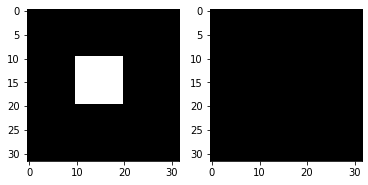

In [ ]:
import torch
import matplotlib.pyplot as plt
# validate some important concepts 
negative_example = torch.zeros([32,32])
positive_example = torch.zeros([32,32])
positive_example[10:20,10:20] = 1

plt.figure("Positive Example vs Negative Example")
plt.subplot(121)
plt.imshow(positive_example,cmap = "bone")
plt.subplot(122)
plt.imshow(negative_example,cmap = "bone")

In [ ]:
import torch.nn as nn

embds = nn.Embedding(2,32)

target = torch.ones([1,32])

all_concepts = embds(positive_example.long()).flatten(start_dim = 0,end_dim = 1)
score = torch.sigmoid(torch.cosine_similarity(all_concepts,target) * 4)

exist_prob = torch.max(score)
print(exist_prob)


optimizer = torch.optim.Adam(embds.parameters(), lr = 2e-3)

for epoch in range(1000):
    loss = 0

    # calculate scores for the positive example
    all_concepts = embds(positive_example.long()).flatten(start_dim = 0,end_dim = 1)
    score = torch.sigmoid(torch.cosine_similarity(all_concepts,target) * 4)
    score_dist1 = score.reshape(32,32)

    exist_prob = torch.max(score)
    loss -= torch.log(exist_prob)

    # calculate scores for the negative example
    all_concepts = embds(negative_example.long()).flatten(start_dim = 0,end_dim = 1)
    score = torch.sigmoid(torch.cosine_similarity(all_concepts,target) * 4)
    score_dist2 = score.reshape(32,32)
    exist_prob = torch.max(score)
    dne_prob = 1 - exist_prob

    loss -= torch.log(dne_prob)



    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

all_concepts = embds(positive_example.long()).flatten(start_dim = 0,end_dim = 1)
score = torch.sigmoid(torch.cosine_similarity(all_concepts,target) * 4)

score_dist1 = score.reshape(32,32)

exist_prob = torch.max(score)

print(exist_prob)

all_concepts = embds(negative_example.long()).flatten(start_dim = 0,end_dim = 1)
score = torch.sigmoid(torch.cosine_similarity(all_concepts,target) * 4)

score_dist2 = score.reshape(32,32)

exist_prob = torch.max(score)
dne_prob = 1 - exist_prob
print(exist_prob,dne_prob)



tensor(0.8358, grad_fn=<MaxBackward1>)
tensor(0.9743, grad_fn=<MaxBackward1>)
tensor(0.0392, grad_fn=<MaxBackward1>) tensor(0.9608, grad_fn=<RsubBackward1>)


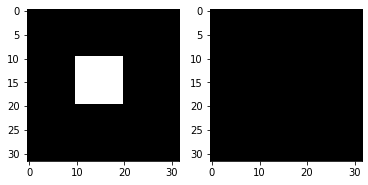

In [ ]:
plt.figure("Concept Score")
plt.subplot(121)
plt.imshow(score_dist1.detach(),cmap = "bone")
plt.subplot(122)
plt.imshow(score_dist2.detach(),cmap = "bone")

In [ ]:
"""
力量 57
体质 70
体型 61
智力 50
意志 60
敏捷 60
外表 69
教育 84

SAN: 59
HP: 13

克苏鲁: +12

伤害 : d4
会计 35
Bargin 50
商业能力 70
攀爬 50
信誉 75 
闪避 50
汽车驾驶 60
快速交谈 65
急救 45
跳跃 40
法律 50
图书馆使用 70
聆听 60
说服 50
心理学 60
潜心 55
侦查 60
法语 25
"""

In [ ]:
# [Setup PDSketch]

import argparse 
parser = argparse.ArgumentParser()
parser.add_argument("--predicate_dim",default = 100)
config = parser.parse_args(args = [])


torch.Size([1157, 2]) torch.Size([1157, 32]) torch.Size([2, 8337]) torch.Size([1157])
torch.Size([1157, 2]) torch.Size([1157, 32]) torch.Size([2, 0]) torch.Size([1157])


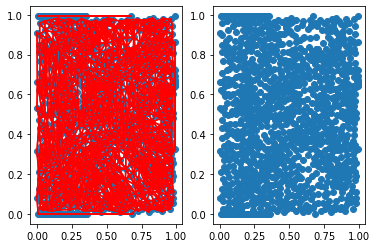

In [20]:
import torch
import torch.nn as nn

import torch.nn.functional as F 

from PSGNetLite import *
import objectsRoomLoader


dataset1 = objectsRoomLoader.MineClip()#BattlecodeImageData()
dataset2 = objectsRoomLoader.MineOut()
dataset3 = objectsRoomLoader.MineCrazy()

dataset = torch.utils.data.ConcatDataset([dataset2,dataset1,dataset3])
train_dataloader = torch.utils.data.DataLoader(dataset,batch_size = batch_size, shuffle = True)

inputs = dataset[2]["image"].unsqueeze(0)

net = torch.load("checkpoints/constant_qtr_model.ckpt")

outputs = net(inputs)

levels = outputs["levels"]


def render_level(level,name = "Namo"):

    plt.scatter(level.centroids[:,0],level.centroids[:,1])
    row,col = level.edges
    data = []
    rc,cc = level.centroids[row],level.centroids[col]

    for i in range(len(rc)):
        point1 = rc[i];point2 = cc[i]
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        plt.plot(x_values,y_values,color = "red")

for i,level in enumerate(levels):
        plt.subplot(1,len(levels),i + 1)
        render_level(level,"Namo")
